In [1]:
# 4개의 군집으로 그룹화하는 K-평균 알고리즘 구현 코드
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

num_points = 2000
vectors_set = []

# K-평균 예제를 실습하기 위해 샘플 데이터를 생성합니다.
# 두 개의 정규분포를 이용하여 2D(2차원) 좌표계에 2000개의 점을 랜덤하게 생성하겠습니다.
for i in range(num_points):
    if np.random.random() > 0.5:
        vectors_set.append([np.random.normal(0.0, 0.9), np.random.normal(0.0, 0.9)])
    else:
        vectors_set.append([np.random.normal(3.0, 0.5), np.random.normal(1.0, 0.5)])

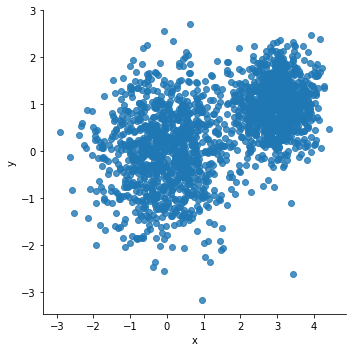

In [7]:
# 파이썬의 그래픽 라이브러리에서 matplotlib을 기반으로 하는 seaborn 시각화 패키지를 이용하겠습니다.
# 또한 좀 더 복잡한 형태의 데이터를 다루기 위해 데이터 조작 패키지 pandas를 사용하겠습니다.
# pandas는 데이타 분석(Data Analysis)을 위해 널리 사용되는 파이썬 라이브러리 패키지이다.
# 2차원 자료구조인 DataFrame는 행과 열이 있는 테이블 데이타(Tabular Data)를 받아들이는데, 
# 아래 예제는 그 한가지 방법으로서 열(column)을 dict의 Key로, 행(row)을 dict의 Value로 한 Dictionary 데이타를 
# pd.DataFrame()을 사용하여 pandas의 Data Frame 자료구조로 변환한 예이다.

df = pd.DataFrame({"x": [v[0] for v in vectors_set], "y": [v[1] for v in vectors_set]})
sns.lmplot("x", "y", data=df, fit_reg=False, height=5, legend=False)
plt.show()

In [31]:
# 모든 학습 데이터를 텐서에 할당합니다.
vectors = tf.constant(vectors_set)
k = 4
# K-Means 알고리즘은 임의의 좌표로 초기중심 K개를 지정하기 위해 
# 입력 데이터에서 무작위로 K개의 데이터를 선택하는 방법을 구현하기 위해
# 텐서플로가 입력 데이터를 무작위로 섞어서 K개의 중심을 선택하게 했습니다.
centroides = tf.Variable(tf.slice(tf.random_shuffle(vectors),[0,0],[k,-1]))
# 텐서의 구조를 확인
#print(vectors.get_shape())
#print(centroides.get_shape())
# vectors는 2차원 구조이며 D0차원의 크기는 2000개이고 D1차원의 크기는 2개입니다.
# centroides는 2차원 구조이며 D0차원의 크기는 4이고 D1차원의 크기는 2개입니다.

# 유클리드 제곱거리를 연산하기 위해 vectors와 centroides의 차원을 맞춰야 합니다.
# 차원을 확장하기 위해 expand_dims 함수를 사용합니다.
# vectors는 D0차원을 추가하고 centroides는 D1차원을 추가합니다.
# vectors와 centroides는 2D에서 3D으로 변경됩니다.
# 텐서플로의 브로드캐스팅 기능 덕분에 tf.sub 함수는 두 텐서의 각 원소를 어떻
# 크기가 1인 차원은 텐서 연산 시 ㅣ다른 텐서의 해당 차원 크기에 맞게 계산을 반복하므로 마치 차원이 늘어난 것 같은 효과를 가집니다.
# 각 점(데이터)에 대해 유클리드 제곱 거리를 구해 가장 가까운 중심을 계산
expanded_vectors = tf.expand_dims(vectors, 0)
expanded_centroides = tf.expand_dims(centroides, 1)

#assignments = tf.argmin(tf.reduce_sum(tf.square(tf.sub(sxpanded_vectors, expanded_centroides)), 2), 0)
# expaned_vectors와 expanded_centroids 뺄셈
diff = tf.subtract(expanded_vectors, expanded_centroides)
diff_sqr = tf.square(diff)
# 지정한 차원 축소
# D2를 기준으로 차원을 줄입니다.
distances = tf.reduce_sum(diff_sqr, 2)
# 지정한 차원(D0을 기준)에서 가장 작은 값의 원소의 인덱스를 리턴
assignments = tf.argmin(distances,0)
# 각 변수 구조 확인하기... get_shape()
print(assignments[0])
print(vectors.get_shape())
print(centroides.get_shape())

Tensor("strided_slice_8:0", shape=(), dtype=int64)
(2000, 2)
(4, 2)


In [32]:
# K개 군집에 속하는 점들의 평균을 가진 K개의 텐서를 함쳐서(concatenate) mean 텐서를 만듭니다.
# equal 함수를 사용하여 한 군집과 매칭되는 assignments 텐서의 각 원소 위치를 True로 표시하는 불리언 텐서(Dimension(2000))를 만듭니다.
# 군집의 번호를 변수 C에 매핑합니다.
# where 함수를 사용하여 매개변수로 받은 불리언 텐서에서 True로 표시된 위치를 값으로 가지는 텐서(Dimension(2000)*Dimension(1))를 만듭니다.
# 단, 중간에 코드로 구조를 확인해보면 세션 실행 전이므로 차원의 크기가 결정되지 않아 Dimension(2000) 대신 Dimension(None)으로 나옵니다.
# reshape함수를 사용하여 c군집에 속한 vectors 텐서의 포인트들의 인덱스로 구성된 텐서(Dimension(2000)*Dimension(2))를 만듭니다.
# gather 함수를 사용하여 c 군집을 이루는 점들의 좌표를 모은 텐서(Dimension(1)*Dimension(2000)*Dimension(2))를 만듭니다.
# reduce_mean 함수를 사용하여 c 구닙에 속한 모든 점의 편균 값을 가진 텐서 (Dimension(1)*Dimenstion(2))를 만듭니다.
means = tf.concat([tf.reduce_mean(tf.gather(vectors,
                                            tf.reshape(tf.where(tf.equal(assignments, c)), [1,-1])),
                                            reduction_indices=[1]) for c in range(k)],0)

# 중심을 means 텐서의 새 값으로 업데이트하는 코드를 살펴보겠습니다.
# means 텐서의 값을 centroids에 할당하는 연산해야 합니다.
# 그래야 run() 메서드가 실행될 때 업데이트된 중심 값이 다음번 루프에서 사용될 수 있기 때문입니다.
update_centroides = tf.assign(centroides, means)

In [33]:
# 데이터 그래프를 실행하기 전에 모든 변수를 초기화하
init_op = tf.global_variables_initializer()

# 데이터 그래프를 실행
# 코드를 통해 매 반복마다 중심은 업데이트되고 각 점은 새롭게 군집에 할당 됩니다.
# 이 코드에서 매개변수로 지정한 세 개의 연산은 run() 함수를 호출하는 순간 지정한 순서대로 실행됩니다.
# 그로고 찾아야 할 값이 세 개이므로 sess.run()은 훈련 과정 동안 세 개의 연산에 상응하는 텐서 세 개를 numpy 배열로 만들어 리턴합니다.
# update_centroides 연산은 리턴값이 없으므로 _(밑줄)을 사용해 결과를 버리게 했습니다.
# (사실 _도 다른 변수와 똑같이 변수이지만, 파이썬 사용자들은 결과를 버릴 때 _을 사용하는 것이 관습입니다.)
sess = tf.Session()
sess.run(init_op)

for step in range(100):
    _, centroid_values, assignment_values = sess.run([update_centroides, centroides, assignments])

print(centroid_values)

[[ 0.59646297  0.05637861]
 [ 2.65524     1.2613913 ]
 [ 3.3152843   0.7246466 ]
 [-0.7759162  -0.17438455]]


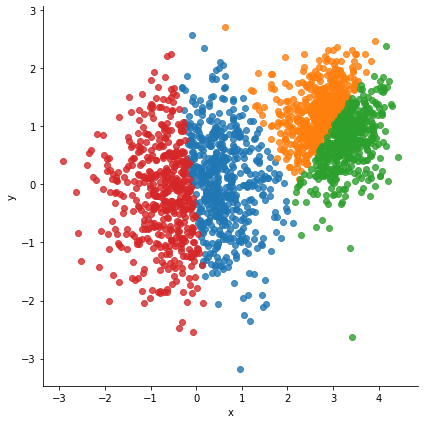

In [34]:
# assignment_values 텐서의 결과를 확인해 보기 위해 다음 코드를 작성합니다.
data={"x":[], "y":[], "cluster":[]}

for i in range(len(assignment_values)):
    data["x"].append(vectors_set[i][0])
    data["y"].append(vectors_set[i][1])
    data["cluster"].append(assignment_values[i])
    
df = pd.DataFrame(data)
sns.lmplot("x", "y", data=df, fit_reg=False, height=6, hue="cluster", legend=False)
plt.show()